# Board Game Ranking Project Overview:

## Introduction:
This project uses the BoardGameGeek (BGG) dataset, encompassing user comments and liking scores for almost 30,000 board games. Users can comment and rate games, contributing to a ranking system that reflects user preferences. Unlike traditional ratings, BGG's ranking relies on user-generated comments and its own algorithm to offer a better representation of board game popularity.

### Objective:
The project aims to establish an alternative game ranking based on user liking, accounting for varying comment counts. The goal is to offer a nuanced and representative game ranking that better captures the diversity of user preferences within the BGG database.



In [2]:
##  Importing necessary libraries 
import pandas as pd
# Library for data manipulation and analysis. Provides data structures and facilitates handling and analyzing structured data.

import numpy as np
# Numerical Python library that provides support for large, multi-dimensional arrays and matrices, along with mathematical functions to operate on these arrays

import matplotlib.pyplot as plt
# Library for creating interactive visualisations

from scipy.stats import norm 
# Submodule of SciPy, this library provides support for statistical functions

import seaborn as sns
# Built on top of matplotlib, library for better statistical data visualisation 

### Initial Problem:
The conventional average ranking method although intuitive lacks in the representation of sample size, particularly when dealing with a low number of ratings. This is evident when comparing items with significantly different positive and negative ratings. The project addresses this limitation by proposing an alternative ranking strategy tailored to the BGG dataset.


### BGG Ranking:
While BGG provides an average rating, it also introduces its Geek ranking, calculated through an undisclosed algorithm.

According top the official BGG website, the Geek Ranking operates as a Bayesian average, incorporating external assumptions into the calculation. 
It involves seeding the average with a substantial number of dummy ratings and excluding certain ones to maintain legitimacy, potentially omitting newer or less active accounts.By this method, games with larger audiences and more ratings are favored in BGG's Geek Rating and ranking system. 
However, for less known games, achieving a high Geek Score and BGG rating can be challenging, making average scores more crucial for visibility on a game's page.

Since we don't have access to the official Geek Ranking, we can create a data frame with the top 20 Geek Ranking Board game and compare them firstly with their average user-ratings. 


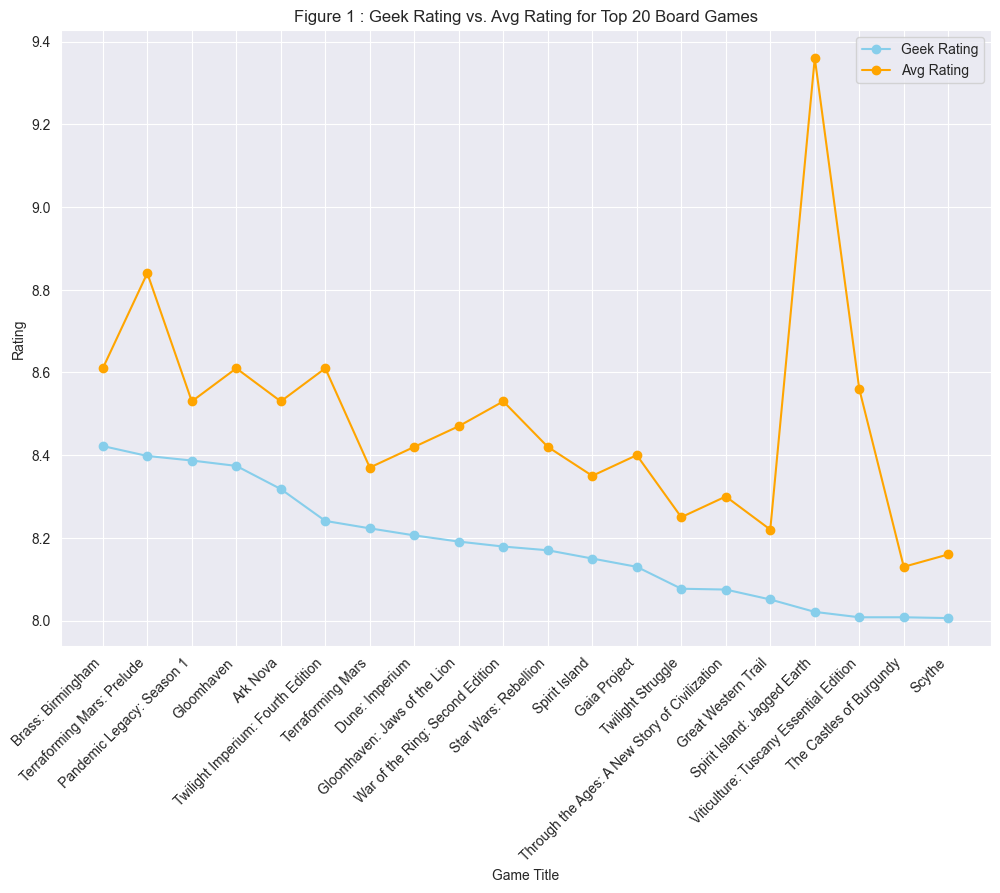

In [3]:
# Comparing Geek top 20 games (as of Friday 17th of November 2023) 

# Create Data frame with top 20 geek ranking games and their respective ratings
# Define the data
dt = {
    'g_ranking': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'title': [
        'Brass: Birmingham', 'Terraforming Mars: Prelude', 'Pandemic Legacy: Season 1',
        'Gloomhaven', 'Ark Nova', 'Twilight Imperium: Fourth Edition', 'Terraforming Mars',
        'Dune: Imperium', 'Gloomhaven: Jaws of the Lion', 'War of the Ring: Second Edition',
        'Star Wars: Rebellion', 'Spirit Island', 'Gaia Project', 'Twilight Struggle',
        'Through the Ages: A New Story of Civilization', 'Great Western Trail', 'Spirit Island: Jagged Earth',
        'Viticulture: Tuscany Essential Edition', 'The Castles of Burgundy', 'Scythe'
    ],
    'g_rating': [8.422, 8.398, 8.387, 8.374, 8.318, 8.241, 8.223, 8.206, 8.191, 8.179, 8.170, 8.150, 8.130, 8.077, 8.075, 8.051, 8.021, 8.008, 8.008, 8.006],
    'avg_rating': [8.61, 8.84, 8.53, 8.61, 8.53, 8.61, 8.37, 8.42, 8.47, 8.53, 8.42, 8.35, 8.40, 8.25, 8.30, 8.22, 9.36, 8.56, 8.13, 8.16],
    'num_voters': [41667, 14229, 51825, 60101, 36428, 22008, 93646, 39130, 31335, 20010, 30962, 47211, 25696, 47550, 30490, 39510, 4078, 9581, 59614, 79513]
}

# Create a DataFrame
geek_df = pd.DataFrame(dt)

# Sort the DataFrame by 'g_rating' in descending order to maintain the ranking
df_sorted = geek_df.sort_values(by='g_rating', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(df_sorted.head(20)['title'], df_sorted.head(20)['g_rating'], label='Geek Rating', marker='o', color='skyblue')
plt.plot(df_sorted.head(20)['title'], df_sorted.head(20)['avg_rating'], label='Avg Rating', marker='o', color='orange')
plt.xlabel('Game Title')
plt.ylabel('Rating')
plt.title('Figure 1 : Geek Rating vs. Avg Rating for Top 20 Board Games')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

As shown in Figure 1, the Geek Ranking is characterised by its conservative nature, providing a more balanced assessment of game scores. Indeed the use of Bayesian average method offers more accuracy by considering both the overall rating and the sample size, resulting in a more accurate evaluation and ranking. Notably, no game, even those ranked at the top, receives a perfect rating of 10.

## Cleaning our Data 
To create an alternative to the Geek and Average ranking, we must manipulate and clean the BGG dataset for further manipulations. 


### Descriptive statistics of the BGG data set 

In [4]:
bgg = pd.read_csv('bgg.csv')
summary = bgg.describe()
bgg = pd.DataFrame(bgg)
# Print the summary
print(summary)

               game         rating
count  1.082167e+06  706813.000000
mean   8.524701e+04       6.423427
std    8.958489e+04       1.907699
min    1.000000e+00       0.000000
25%    7.499000e+03       5.000000
50%    3.441900e+04       6.950000
75%    1.636400e+05       8.000000
max    3.101000e+05      10.000000


### Dataset summary :
 The dataset comprises over one million entries for games, with 706,813 non-null ratings. The average rating is around 6.42, indicating moderate variability (std: 1.91). Ratings range from 0 to 10, with a median of 6.95. Quartile analysis reveals a balanced spread, with 25% below 5 and 75% below 8.
 
### Null Values 
BGG websites allows for comments on board games without any rating, resulting in some reviews without a numerical rating, which are encoded as null values. We can calculate the proportion of null values in BGG data set. 


In [5]:
null_proportion = bgg['rating'].isnull().mean()
print('Proportion of Null Values in BGG dataset')
print(null_proportion)

Proportion of Null Values in BGG dataset
0.3468540437843697


We observe that around 35% of all reviews have missing values, which could have significant implications when looking to rank the board games. Missing values might introduce bias and impact the reliability of the ranking but also skew final results.

Instead of dropping NAs, we will impute missing values with the average group mean, on a per board game basis. 

In [6]:
bgg['rating'] = bgg.groupby('game')['rating'].transform(lambda x: x.fillna(x.mean()))

# two board games have only written reviews with no ratings, we can drop these board game from our dataset 
bgg.dropna(subset=['rating'], inplace=True)

print(bgg.isna().any().any())

False


By doing so we are preserving data structure, reducing bias, and enhancing robustness by tailoring imputations to each game's rating pattern. 
However, this approach assumes similarity among games within the same group and may underestimate variability within groups.    

## Wilson Score 

### Definition and uses 
The Wilson Score is a statistical method employed to estimate confidence intervals for proportions. It proves beneficial when dealing with limited data samples and is considered for its ability to offer reliable insights into the likely range of true proportions. 


### Key Aspects:
### Point Estimate:
The Wilson Score delivers a point estimate, representing the central value for the true proportion of positive outcomes. It serves as the most probable value within the confidence interval.
### Confidence Interval:
Using a 95% confidence level, the Wilson Score constructs a confidence interval around the point estimate, which provides a reasonable range where the true proportion is likely to exist.

### Using the Wilson Score for game ratings 
In our case, the wilson score seems appropriate to use as it :  
1. Allows for small sample size 
2. Balances positive and negative ratings 
3. Provides Confidence Intervals 
4. Reflects User preferences 
5. Aligns with the idea of User-Centric Approach 


## Wilson Score Function 
### Creating a dummy variable 
In order to obtain the wilson scores of each board game we need to create an associated dummy variable, and define if a game is considered liked or not. 

BGG website provides this rating guideline : 

10 - Outstanding. Always want to play, expect this will never change.
9 - Excellent. Always want to play.
8 - Very good. Like to play, will probably suggest it, and will never turn it down.
7 - Good. Usually willing to play.
6 - Fair. Some fun or challenge at least, will play occasionally if in the right mood.
5 - Average. No significant appeal, take it or leave it.
4 - Below average. Slightly boring, could be talked into it on occasion.
3 - Poor. Likely won't play this again although could be convinced.
2 - Very poor. Annoying, I plan to never play this again.
1 - Defies description of a game. You won't catch me dead playing this. Clearly broken.

In our case we want to rank the most liked games, and we will set our threshold at 7 and above. "Liked" games will be assigned a value of 1, and otherwise  a value of 0 

In [7]:
##Creating liked column 
bgg['liked'] = bgg['rating'].apply(lambda x: 1 if x >= 7.0 else 0)
bgg.to_csv('modified_bgg.csv', index=False)

mod_bgg = pd.read_csv('modified_bgg.csv')

### Calculate Wilson score for each games 

In [8]:
def wilson_score(liked_count, # number of time the game was liked
                 total_count, # total number of rating for the game
                 confidence=0.95 # confidence level for which the true population will lie in
                 ):
    if total_count == 0: # check that if there are no rating for a game.
        return 0.0
    # defining our parameters
    p = liked_count / total_count # calculating proportions of liked ratings
    z = norm.ppf(1 - (1 - confidence) / 2) # calculating the Z score corresponding to the desire level of confidence using inverse normal distribution

    lower_bound = (p + z ** 2 / (2 * total_count) - z * np.sqrt(
        (p * (1 - p) + z ** 2 / (4 * total_count)) / total_count)) / (1 + z ** 2 / total_count) # adjust proportion of liked ratings to the sample size (total_count)

    return lower_bound




In [9]:
# Use group_by function 
wilson_scores = (bgg.groupby('game') # group the dataframe by game
                 .apply(lambda x: wilson_score(sum(x['liked']), len(x['liked'])))) # applies W-score to each game

In [10]:
# Add the calculated Wilson scores to the DataFrame
wilson_df = pd.DataFrame({'game': wilson_scores.index, 'wilson_score': wilson_scores.values})

wilson_df.to_csv('Wilson.Score.csv')

In [11]:
# Merge the Wilson scores back to the original DataFrame
wilson = pd.merge(mod_bgg, wilson_df, on='game')
wilson = pd.DataFrame(wilson)

# Step 1: Calculate average rating for each title by grouping by 'title'
average_rating_per_title = wilson.groupby('game')['rating'].mean().reset_index()
average_rating_per_title.columns = ['game', 'average_rating']

# Step 2: Create a new DataFrame with game, title, average rating, Wilson score
# Group by title and calculate the mean Wilson score for each title
wilson = wilson.groupby('game').agg({
    'title': 'first',  # Assuming 'game' is the same for each title
    'wilson_score': 'mean'
}).reset_index()

# Merge average rating into the grouped_df DataFrame
wilson = pd.merge(wilson, average_rating_per_title, on='game')

# Create a new column 'adjusted_wilson' by multiplying 'wilson_score' by 10
wilson['adjusted_wilson'] = wilson['wilson_score'] * 10

print(wilson)


         game                   title  wilson_score  average_rating  \
0           1              Die Macher      0.744520        7.645890   
1           2            Dragonmaster      0.263642        6.619118   
2           3                 Samurai      0.801879        7.630952   
3           4          Tal der Könige      0.254615        6.558219   
4           5                 Acquire      0.744520        7.584375   
...       ...                     ...           ...             ...   
23805  305682          Rolling Realms      0.767199        7.301765   
23806  306494        Rolling Village!      0.657953        7.036842   
23807  306577  Der Clou: Roll & Heist      0.782020        8.714286   
23808  308565             Roll n Cook      0.686059        8.400000   
23809  310100       Nemesis: Lockdown      0.929988        8.000000   

       adjusted_wilson  
0             7.445200  
1             2.636425  
2             8.018790  
3             2.546152  
4             7.445200

## Comparing Both Methods and Performances 


### 1. Average Rating distribution 

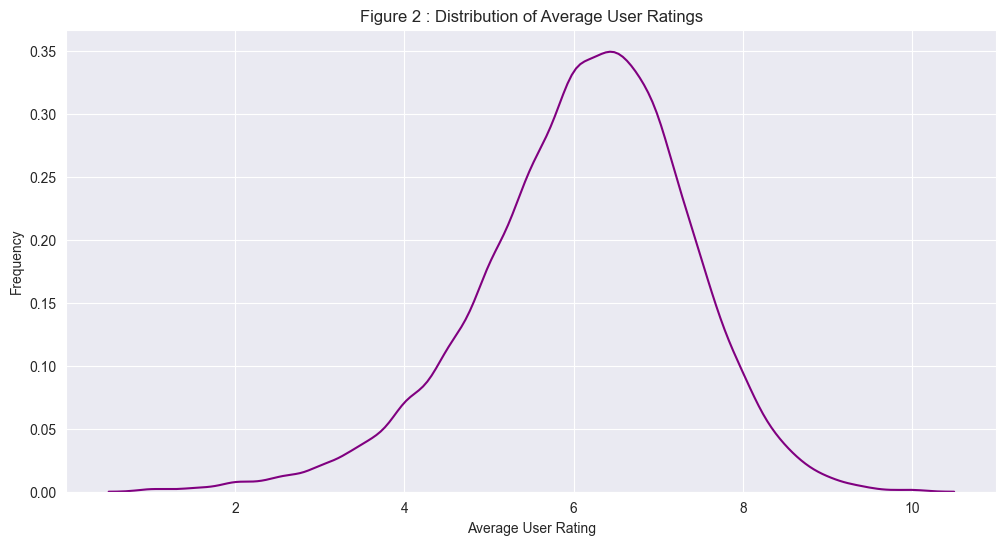

count    23810.000000
mean         6.112833
std          1.230023
min          1.000000
25%          5.388949
50%          6.214286
75%          6.953079
max         10.000000
Name: average_rating, dtype: float64


In [12]:
# create distribution of average rating
plt.figure(figsize=(12, 6))
sns.kdeplot(wilson['average_rating'], color='purple')
plt.xlabel('Average User Rating')
plt.ylabel('Frequency')
plt.title('Figure 2 : Distribution of Average User Ratings')
plt.show()

sum = wilson['average_rating'].describe()
print(sum)

### Comments : 
With a mean rating of approximately 6.11 and a moderate standard deviation of 1.23, the ratings display a certain level of variability. The 25th percentile at 5.39 and the 75th percentile at 6.95 indicate that a significant portion of games falls within this range, highlighting a concentration of ratings around the middle. The presence of both the minimum and maximum ratings at 1.0 and 10.0 suggests a diverse spectrum of opinions, capturing both poorly and highly regarded games.

### 2. Wilson-Score distribution 

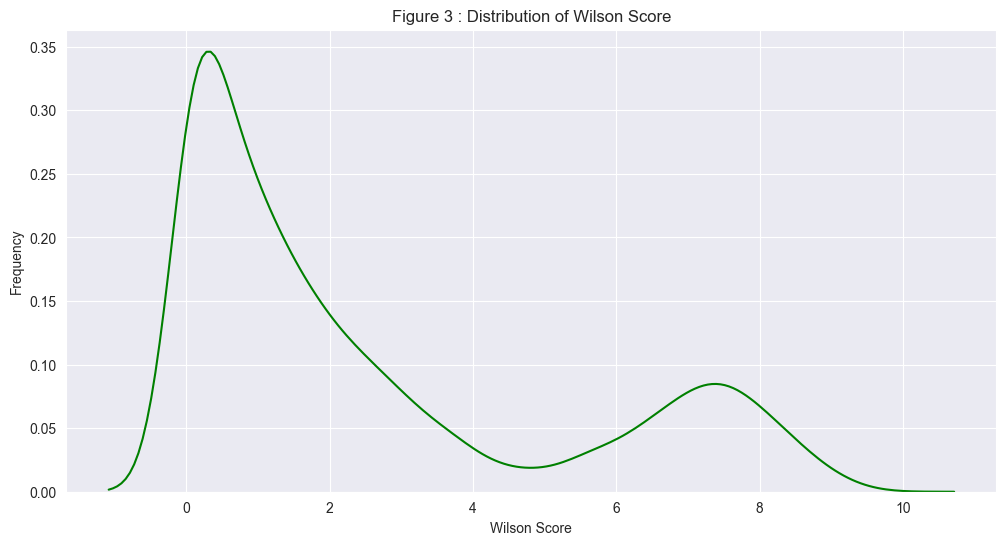

count    2.381000e+04
mean     2.518270e+00
std      2.704957e+00
min     -1.173174e-16
25%      3.852035e-01
50%      1.381201e+00
75%      3.751082e+00
max      9.630065e+00
Name: adjusted_wilson, dtype: float64


In [13]:
# create distribution of Wilson score
plt.figure(figsize=(12, 6))
sns.kdeplot(wilson['adjusted_wilson'], color='green')
plt.xlabel('Wilson Score')
plt.ylabel('Frequency')
plt.title('Figure 3 : Distribution of Wilson Score')
plt.show()

sum1 = wilson['adjusted_wilson'].describe()
print(sum1)

### Comments : 
The mean Wilson score is approximately 2.52, with a standard deviation of 2.70, indicating a moderate level of variability. The minimum value, close to zero, implies that some games may have received low scores, potentially reflecting negative opinions or minimal user engagement. The 25th percentile at 0.39 and the 75th percentile at 3.75 suggest a skewed distribution, emphasizing the prevalence of games with lower Wilson scores. The maximum Wilson score of 9.63 signifies the upper limit of the confidence interval, highlighting the highest-rated games with a high degree of certainty   

## Comparing scores ratings methods

### Plotting our dataset 

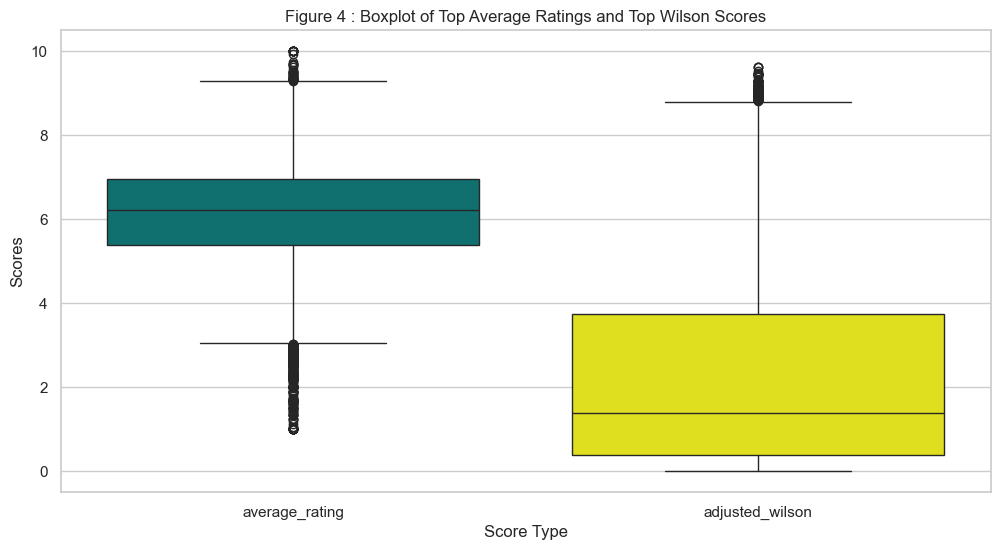

In [14]:
## Boxplot comparing both methods 

# Set the style for Seaborn
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define data and colors
data = wilson[['average_rating', 'adjusted_wilson']]
colors = ['teal', 'yellow']

# Plot boxplot for top average ratings and top Wilson scores
sns.boxplot(data=data, palette=colors, ax=ax)
ax.set_xlabel('Score Type')
ax.set_ylabel('Scores')

# Title and legend
plt.title('Figure 4 : Boxplot of Top Average Ratings and Top Wilson Scores')

# Show the plot
plt.show()

### Comments : 
The boxplot in Figure 4 compares top average ratings and top Wilson scores for board games. For average ratings, the tail, around 3,  and head , around 4,  depict the lowest and highest scores, indicating the range and presence of outliers. In contrast, Wilson scores show a broader range from around 0 to 8 , with over 75% of scores below 4, and fewer outliers.  

## Differences between score assignments

With our two methods, we can look at the average differences between the two rankings.  

In [15]:
# Sort the DataFrame by 'average_rating' and 'wilson_score'
sorted_by_rating = wilson.sort_values(by='average_rating', ascending=False)
sorted_by_wilson = wilson.sort_values(by='adjusted_wilson', ascending=False)


# Calculate the difference between adjusted Wilson score and average rating
wilson['score_difference'] = wilson['adjusted_wilson'] - wilson['average_rating']

# Calculate the average difference
average_difference = wilson['score_difference'].mean()

print(f'Average Difference: {average_difference}')

Average Difference: -3.594562963761282


On average, the Wilson scores exhibit a 3.6-point lower estimate compared to the average rating method, indicating a more conservative approach by the Wilson score. Given the substantial difference of 3.6 points, it's crucial to note the significant variation in Wilson scores, as evident in the score distribution. 

Therefore, for more nuanced interpretations and conclusive findings on method performance, a focus on the extremes—worst and best-ranked games—would be more beneficial.

We will report the average differences between Wilson scores and average ratings for various subsets of games provide insights into the method's impact across different ranking levels

In [16]:
# Calculate the difference between adjusted Wilson score and average rating for top 20 games
top_20_avg = wilson.sort_values(by='average_rating', ascending=False).head(20)
top_20_avg['score_difference'] = top_20_avg['adjusted_wilson'] - top_20_avg['average_rating']
dif_top_20_avg = top_20_avg['score_difference'].mean()
print(f'Average Difference (Top 20 Avg Rating): {dif_top_20_avg}')

top_200_avg = wilson.sort_values(by='average_rating', ascending=False).head(200)
top_200_avg['score_difference'] = top_200_avg['adjusted_wilson'] - top_200_avg['average_rating']
dif_top_200_avg = top_200_avg['score_difference'].mean()
print(f'Average Difference (Top 200 Avg Rating): {dif_top_200_avg}')

top_2000_avg = wilson.sort_values(by='average_rating', ascending=False).head(2000)
top_2000_avg['score_difference'] = top_2000_avg['adjusted_wilson'] - top_2000_avg['average_rating']
dif_top_2000_avg = top_2000_avg['score_difference'].mean()
print(f'Average Difference (Top 2000 Avg Rating): {dif_top_2000_avg}')

# Calculate the difference between adjusted Wilson score and average rating for bottom 20 games
bottom_20_avg = wilson.sort_values(by='average_rating').head(20)
bottom_20_avg['score_difference'] = bottom_20_avg['adjusted_wilson'] - bottom_20_avg['average_rating']
dif_bottom_20_avg = bottom_20_avg['score_difference'].mean()
print(f'Average Difference (Bottom 20 Avg Rating): {dif_bottom_20_avg}')

bottom_200_avg = wilson.sort_values(by='average_rating').head(200)
bottom_200_avg['score_difference'] = bottom_200_avg['adjusted_wilson'] - bottom_200_avg['average_rating']
dif_bottom_200_avg = bottom_200_avg['score_difference'].mean()
print(f'Average Difference (Bottom 200 Avg Rating): {dif_bottom_200_avg}')

bottom_2000_avg = wilson.sort_values(by='average_rating').head(2000)
bottom_2000_avg['score_difference'] = bottom_2000_avg['adjusted_wilson'] - bottom_2000_avg['average_rating']
dif_bottom_2000_avg = bottom_2000_avg['score_difference'].mean()
print(f'Average Difference (Bottom 2000 Avg Rating): {dif_bottom_2000_avg}')

Average Difference (Top 20 Avg Rating): -2.8762770150398422
Average Difference (Top 200 Avg Rating): -1.4104333455127147
Average Difference (Top 2000 Avg Rating): -0.6533388579722211
Average Difference (Bottom 20 Avg Rating): -1.0337311676082863
Average Difference (Bottom 200 Avg Rating): -1.9508478875777318
Average Difference (Bottom 2000 Avg Rating): -3.485537486586532


### Comments : 
 The observed trends in the average differences between Wilson scores and average ratings provide valuable insights. The substantial average difference of -2.88 for the Top 20 games suggests that the Wilson score tends to be more conservative in estimating user liking compared to the average rating method, particularly for highly-rated games. However, as the analysis extends to larger subsets, the average differences decrease, implying a convergence of the two methods' estimates. This convergence suggests that, for more extensive datasets, the Wilson score method aligns more closely with average ratings.

On the other hand, the pronounced average difference of -3.49 for the Bottom 2000 games highlights the consistent conservative nature of the Wilson score, even in the context of less popular games. This observation indicates that the Wilson score remains conservative in its estimates across various popularity tiers, emphasizing its tendency to provide a more cautious assessment of user liking.

Overall, the average differences suggests that the Wilson score method adapts its conservativeness based on the popularity of games. The wilson score seems to score more conservatively for extreme scores ( perfects 10s or 0s), and therefore possibly a better representation of user sentiment towards a game and its ranking position. 

To further explore these interpretation, we can visualise our data

## Visualisations 

In [17]:
# Select top and bottom games for each criterion
a_20 = sorted_by_rating.head(20)
w_20 = sorted_by_wilson.head(20)


a_200 = sorted_by_rating.head(200)
w_200 = sorted_by_wilson.head(200)

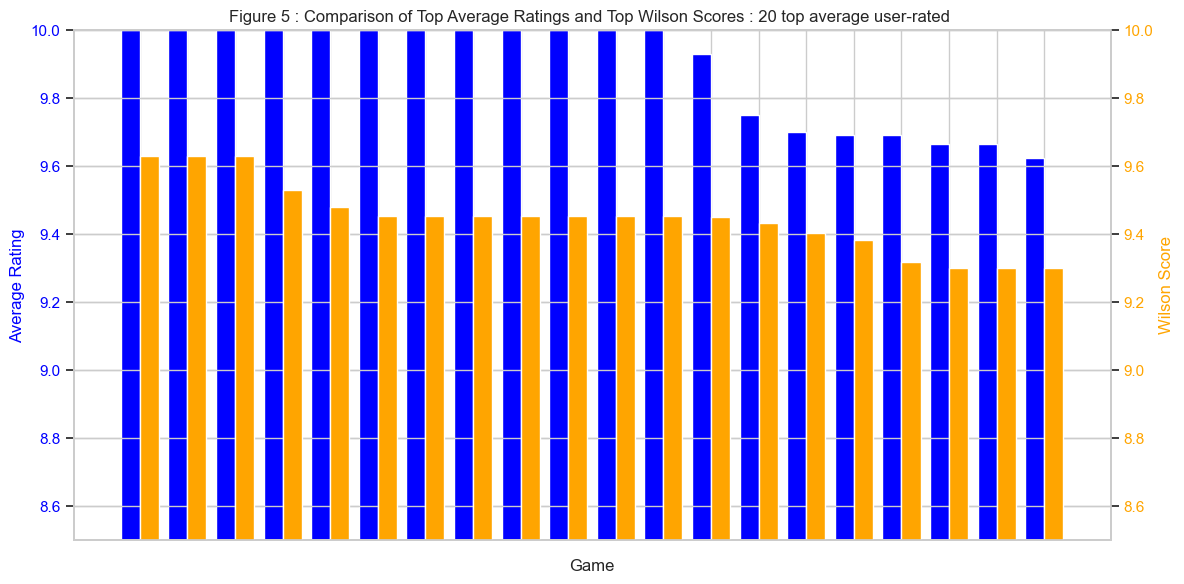

In [18]:
# Top 20 
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))
bar_width = 0.4
index = np.arange(len(a_20['game']))

# Plot bar chart for top average ratings on the primary y-axis
ax1.bar(index, a_20['average_rating'], width=bar_width, label='Top Avg Rating', color='blue')
ax1.set_xlabel('Game')
ax1.set_ylabel('Average Rating', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels([])

# Set y-axis limits for top average ratings
ax1.set_ylim(8.5, 10)

# Create a secondary y-axis for top Wilson scores
ax2 = ax1.twinx()
ax2.bar(index + bar_width, w_20['adjusted_wilson'], width=bar_width, label='Top Wilson Score', color='orange')
ax2.set_ylabel('Wilson Score', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Set y-axis limits for top Wilson scores
ax2.set_ylim(8.5, 10)

# Title and legend
plt.title('Figure 5 : Comparison of Top Average Ratings and Top Wilson Scores : 20 top average user-rated ')
fig.tight_layout()

# Show the plot
plt.show()

### Comments : 
From Figure 5, we observe that the first twelves averaged ratings are marked as perfect 10s. Likely due to a limited number of ratings, this potentially elevating less-known games over objectively better ones. Additionally, Wilson scores consistently prove more conservative than average ratings, indicating a more accurate depiction of a game's likability, factoring in sample size proportions. 

The observations reinforce the notion that Wilson scores offer a precise reflection of a game's popularity, notably evident in the top 20 games. 
While this subset highlights Wilson's efficacy, a broader exploration of board games is essential for a comprehensive analysis and to enhance initial interpretations.
 


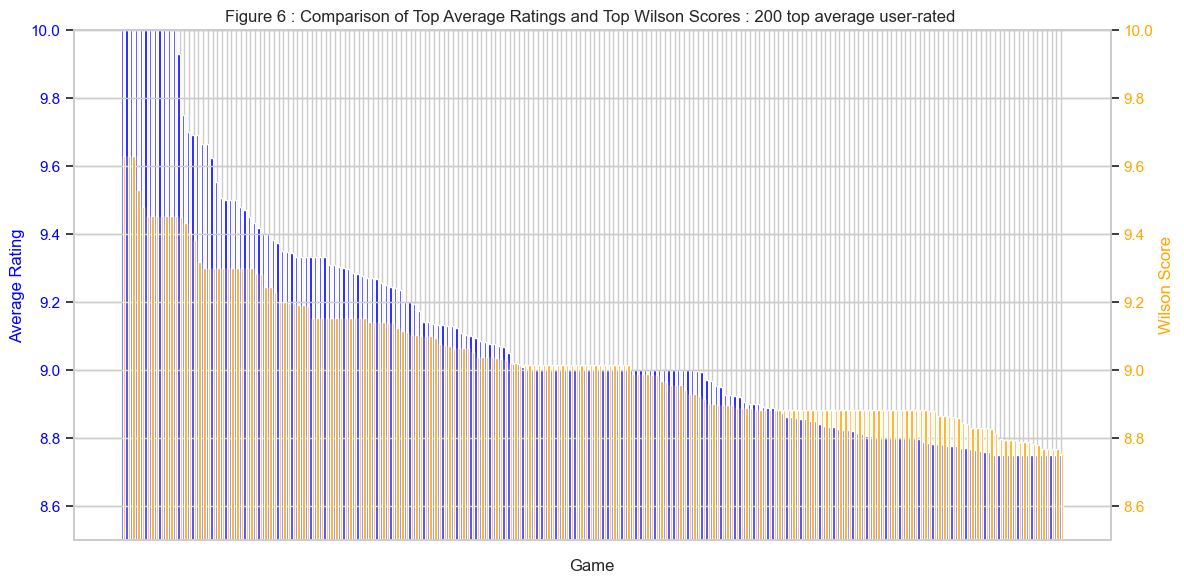

In [20]:
## Top 200 
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))
bar_width = 0.5
index = np.arange(len(a_200['game']))

# Plot bar chart for top average ratings on the primary y-axis
ax1.bar(index, a_200['average_rating'], width=bar_width, label='Top Avg Rating', color='blue')
ax1.set_xlabel('Game')
ax1.set_ylabel('Average Rating', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels([])

# Set y-axis limits for top average ratings
ax1.set_ylim(8.5, 10)

# Create a secondary y-axis for top Wilson scores
ax2 = ax1.twinx()
ax2.bar(index + bar_width, w_200['adjusted_wilson'], width=bar_width, label='Top Wilson Score', color='orange')
ax2.set_ylabel('Wilson Score', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Set y-axis limits for top Wilson scores
ax2.set_ylim(8.5, 10)

# Title and legend
plt.title('Figure 6 : Comparison of Top Average Ratings and Top Wilson Scores : 200 top average user-rated ')
fig.tight_layout()

# Show the plot
plt.show()

### Comments : 
Figure 6 confirms our initial observations. The scores shows less extremity, with Wilson scores maintaining their conservative nature compared to average ratings. 
Notably, as we approach the lower ranks, although the scores align closely, Wilson scores demonstrate greater consistency and progressively mirror the trend seen in average ratings. 

This suggests that Wilson scores provide a representation similar to average rankings but without the influence of extreme values and the unreliability associated with very small sample sizes in average ratings. 

### Wilson Score Performance in Lower Ranked Games 

In [21]:
# Get the minimum and maximum values of the bottom Wilson scores
Lw_2000 = sorted_by_wilson.tail(2000)
min_wilson_score = Lw_2000['adjusted_wilson'].min()
max_wilson_score = Lw_2000['adjusted_wilson'].max()

print(f"Minimum Lower Wilson Score: {min_wilson_score}")
print(f"Maximum Lower Wilson Score: {max_wilson_score}")

Minimum Lower Wilson Score: -1.1731740316366829e-16
Maximum Lower Wilson Score: 3.384324554477539e-16


### Comments : 
As we can observe, the range of Wilson Scores for the lowest-ranked board games is notably narrow, approaching zero. This limited variation aligns with the observed distribution pattern where games tend to be categorized as "not liked." The outcome reflects the strength of Wilson Score in providing precise insights into top-rated board games. However, its effectiveness diminishes when applied to lower-ranked games, making it a less suitable tool for assessing games with lower popularity. 

## Comparing Top ranked wilson Score Games and their associated Average Ratings

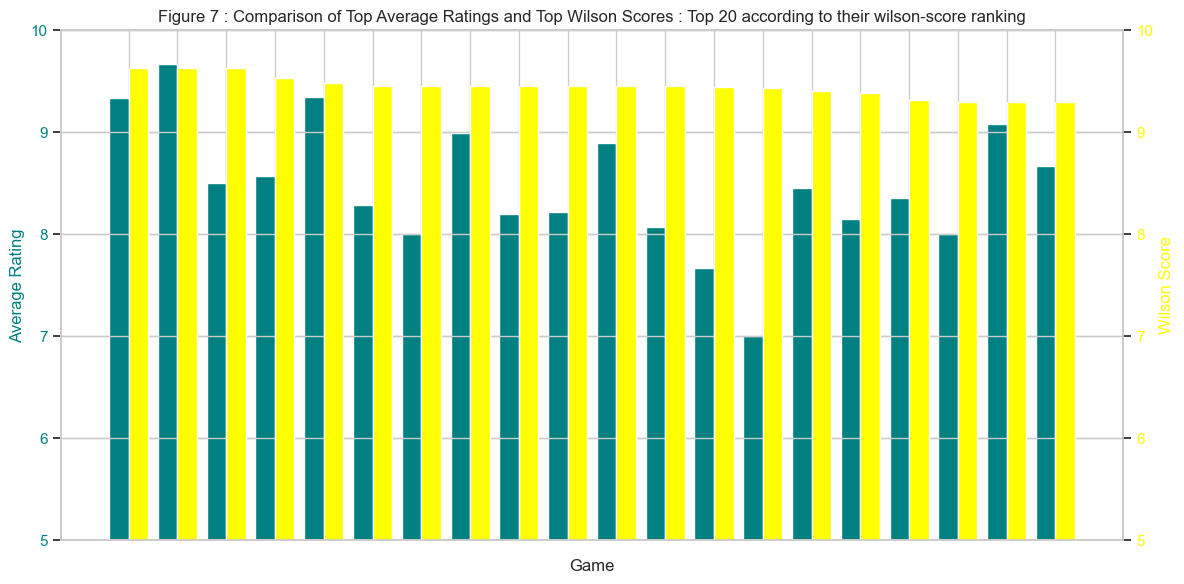

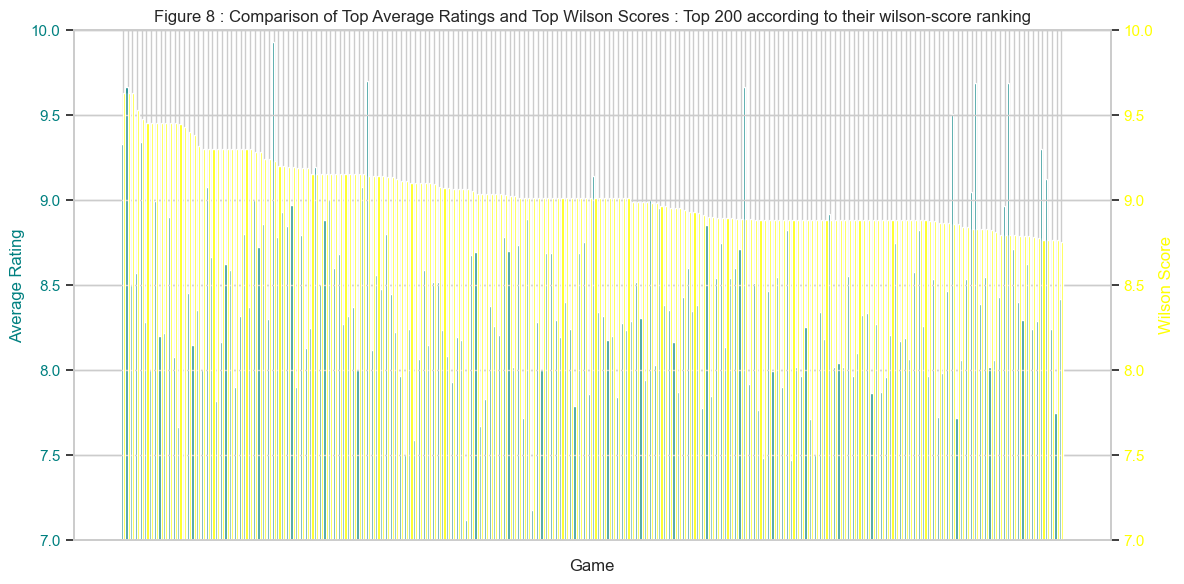

In [22]:
### Plotting the top 200 Board Games Ranking according their Wilson Scores, then comparing the same 200 games and their Average Ratings 

#Top 20 
# Create a figure and axis 
fig, ax1 = plt.subplots(figsize=(12, 6))

bar_width = 0.4
index = np.arange(len(w_20['game']))

# Plot bar chart for top average ratings on the primary y-axis, sorted by top Wilson scores
ax1.bar(index, w_20['average_rating'], width=bar_width, label='Top Avg Rating', color='teal')
ax1.set_xlabel('Game')
ax1.set_ylabel('Average Rating', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels([])

# Set y-axis limits for top average ratings
ax1.set_ylim(5, 10)

# Create a secondary y-axis for top Wilson scores
ax2 = ax1.twinx()
ax2.bar(index + bar_width, w_20['adjusted_wilson'], width=bar_width, label='Top Wilson Score', color='yellow')
ax2.set_ylabel('Wilson Score', color='yellow')
ax2.tick_params(axis='y', labelcolor='yellow')

# Set y-axis limits for top Wilson scores
ax2.set_ylim(5, 10)

# Title and legend
plt.title('Figure 7 : Comparison of Top Average Ratings and Top Wilson Scores : Top 20 according to their wilson-score ranking')
fig.tight_layout()

# Show the plot
plt.show()




##Top 200 
# Create a figure and axis 
fig, ax1 = plt.subplots(figsize=(12, 6))

bar_width = 0.45
index = np.arange(len(w_200['game']))

# Plot bar chart for top average ratings on the primary y-axis, sorted by top Wilson scores
ax1.bar(index, w_200['average_rating'], width=bar_width, label='Top Avg Rating', color='teal')
ax1.set_xlabel('Game')
ax1.set_ylabel('Average Rating', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels([])

# Set y-axis limits for top average ratings
ax1.set_ylim(7, 10)

# Create a secondary y-axis for top Wilson scores
ax2 = ax1.twinx()
ax2.bar(index + bar_width, w_200['adjusted_wilson'], width=bar_width, label='Top Wilson Score', color='yellow')
ax2.set_ylabel('Wilson Score', color='yellow')
ax2.tick_params(axis='y', labelcolor='yellow')

# Set y-axis limits for top Wilson scores
ax2.set_ylim(7, 10)

# Title and legend
plt.title('Figure 8 : Comparison of Top Average Ratings and Top Wilson Scores : Top 200 according to their wilson-score ranking')
fig.tight_layout()

# Show the plot
plt.show()



## Comments : 
By looking at Figure 7 and 8, we can observe a notable disparity emerges in the ranking positions of top-rated board games when comparing Wilson scores to average ratings. The identical games exhibit significantly larger and smaller average ratings than the corresponding Wilson scores assigned to them. This observation underscores the impact of accounting for proportional sample size, suggesting that the Wilson score offers an alternative ranking system that more effectively captures and represents the true popularity of a game.


##  Conclusion 
The BGG website provides an extensive dataset containing ratings and rankings for board games, primarily based on Geek ratings and Average ratings. In addition to these rankings, we created a wilson score ranking which offer an alternative perspective. 

Wilson scores leverage liked/not liked ratios and are proportional to sample size, making them effective even with very small sample sizes. 
This scoring method serves as a middle ground between average ratings, which directly reflect user sentiment but overlook sample size, and the Geek ranking, which prioritises the number of reviews but may penalise lesser-known games. 

The Wilson score serves as a nuanced representation of a game's likability within a group, offering valuable insights for those seeking highly appreciated or acclaimed board games, providing a potentially more informative metric than a straightforward score and ranking.

## Limits and Considerations 
While the Wilson score provides valuable insights, it is essential to acknowledge its inherent limitations for a comprehensive interpretation of rankings. 

Firstly, the mean imputations, employed to address missing data introduce bias. As the mean of other group ratings may not precisely capture sentiment variations within comments. A potential solution could include an evaluation of the language and emotions of comments to derive ratings correlated with sentiment. 

Furthermore, Wilson scores rely on dummy variables, where ratings of 7 or more are considered liked. The subjectivity of such a metric challenges the assignment of wilson scores and in turn may not fully encapsulate sentiment nuances. 
Consequently, the distribution of Wilson scores reveals a skew towards lower assignments, limiting interpretability for middle and lower-ranked games. While Wilson scores offers a good ranking system for top-ranked games, Geek and Average rankings may better serve the assessment of middle and lower-ranked board games, providing a more accurate evaluation.
